In [4]:
import pandas as pd

In [10]:
import matplotlib.pyplot as plt

In [19]:
import dhlab.graph_networkx_louvain as gnl

In [ ]:
import networkx as nx
from itertools import combinations

In [ ]:
def find_faces(G):
    # This is a naive way to find faces; there are more efficient algorithms
    cycle_generator = nx.cycle_basis(G)
    return [tuple(sorted(cycle)) for cycle in cycle_generator]

def dual_graph(G):
    faces = find_faces(G)
    G_dual = nx.Graph()
    
    for i, face1 in enumerate(faces):
        for j, face2 in enumerate(faces[i+1:], start=i+1):
            # Two faces are adjacent if they share more than one vertex
            if len(set(face1).intersection(set(face2))) > 1:
                G_dual.add_edge(i, j)
                
    return G_dual

# Create a simple square graph
G = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1), (1, 3), (2, 4)])

# Compute its dual
G_dual = dual_graph(G)

# Print the edges of the dual graph
print("Edges of the dual graph:", G_dual.edges())

In [12]:
def get_ndt():
    df = pd.read_csv('NDT/ndt_all_reduce.csv', index_col = 0)
    sent = pd.read_csv('NDT/setninger.csv', index_col = 0)
    return df, sent




def make_sentence_graph(indx):
    edges = ndt[ndt.sent_id == indx]["token_order head deprel".split()]
    nodes = ndt[ndt.sent_id == indx]["token_order form".split()]

    #edgelist = [(int(e[1].token_order), int(e[1]['head']), {'name':e[1].deprel}) for e in edges.iterrows()]
    edgelist = [(int(e[1]['head']), int(e[1].token_order), {'name':e[1].deprel}) for e in edges.iterrows()]
    nodelist = [(int(e[1].token_order), {'name':e[1]['form']}) for e in nodes.iterrows()] 

    G = nx.DiGraph()
    
    G.add_edges_from(edgelist)
    G.add_nodes_from(nodelist)
    
    # add name for root element
    G.nodes[0]['name'] = 'root'
   
    return G


def draw_graph(G, rank="BT"):
    edgelabels = {(x[0], x[1]):x[2]['name'] for x in G.edges(data=True)}
    nodelabels = {x[0]:x[1]['name'] for x in G.nodes(data=True)}
    pos =  nx.nx_agraph.graphviz_layout(G, prog="dot")
    G.graph.setdefault('graph', {})['rankdir'] = rank
    n = nx.dag_longest_path(G)
    fig = plt.figure(figsize=(16,1.4*len(n)))
    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 0, "alpha": 0.9}
    nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.3, arrows=True, edge_color='gray') #, connectionstyle="arc3,rad=0.3");
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edgelabels, font_size=8,font_color='orange');
    nx.draw_networkx_labels(G, pos, labels = nodelabels, font_color='darkblue', font_size=12);


In [7]:
ndt, sent = get_ndt()

In [56]:
Gs = [make_sentence_graph(ix+1) for ix in range(1000)]

In [57]:
Gs[0]

In [48]:
def dual_dh_style(G):
    edges = []
    for  x in G.edges(data=True):
        for y in G.edges(data=True):
            if y != x:
                if x[0] == y[1] or y[0] == x[1] or x[1]==y[1] or x[0] == y[0]:
                    edges.append((x[2]['name'], y[2]['name']))
    Gd =nx.from_edgelist(edges)
    Gd.remove_edges_from(nx.selfloop_edges(Gd))
    return Gd

In [59]:
Gds = [dual_dh_style(G) for G in Gs]

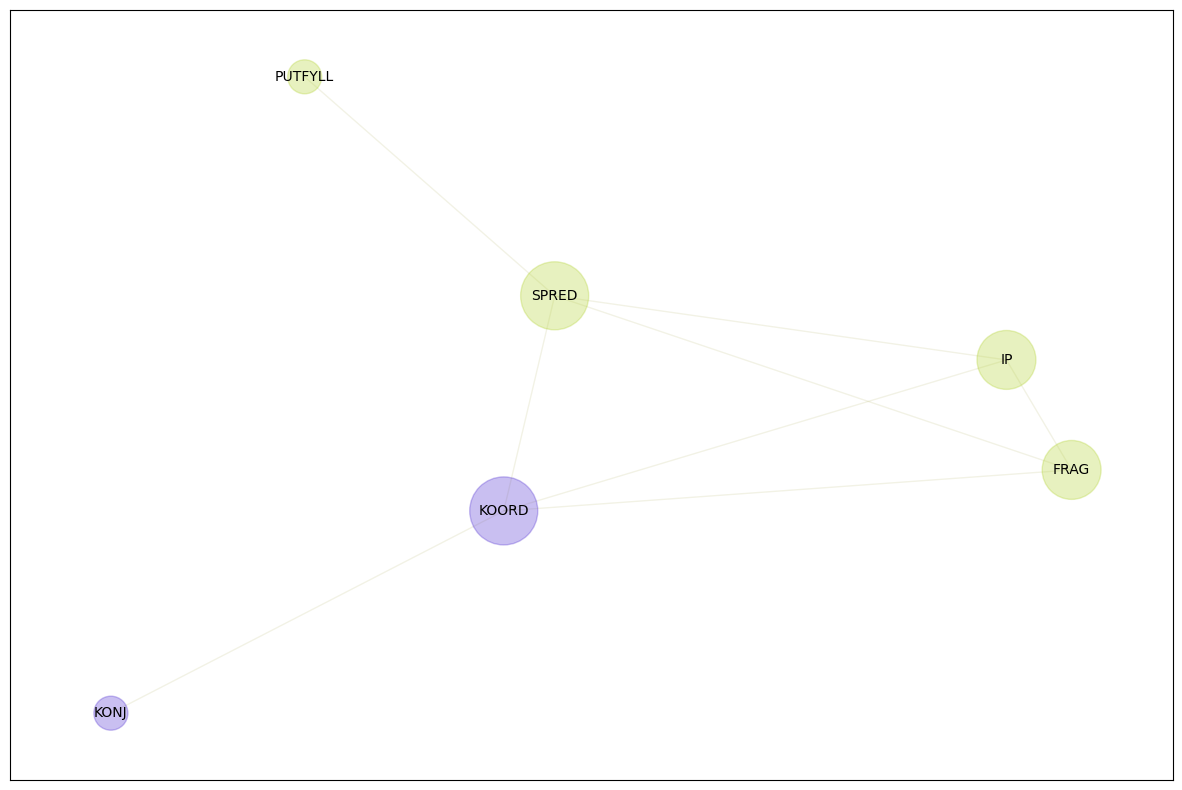

In [60]:
gnl.show_graph(Gds[0])

In [97]:
def to_frame(a_list, name='freq'):
    df = pd.DataFrame(a_list).set_index(0)
    df[name] = 1
    return df

In [100]:
outer_keys = range(100)  # Assuming this is your outer loop range

def inner_keys(G):
    return range(len(gnl.community_dict(G).values()))  # Replace this accordingly

result = pd.concat(
    [
        pd.concat(
            [to_frame(x, "") for j, x in enumerate(gnl.community_dict(Gds[i]).values())],
            axis=1,
            keys=inner_keys(Gds[i])  # Inner MultiIndex keys
        ) 
        for i in outer_keys  # Outer loop
    ],
    axis=1,
    keys=outer_keys  # Outer MultiIndex keys
).fillna(0)

In [ ]:
from sklearn.metrics.

In [105]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


# Convert DataFrame to NumPy array
data_array = result.to_numpy()

# Compute cosine similarity for rows
similarity_rows = cosine_similarity(data_array)
print("Cosine similarity between rows:")
print(similarity_rows)

# Compute cosine similarity for columns
similarity_cols = cosine_similarity(data_array.T)
print("Cosine similarity between columns:")
print(similarity_cols)


Cosine similarity between rows:
[[1.         0.05063697 0.36829475 0.10300524 0.02414023 0.13587324
  0.06004806 0.0930726  0.10895341 0.29184818 0.37768588 0.37133777
  0.0877058  0.10251155 0.03338903 0.29649973 0.13587324 0.
  0.06537205 0.39629696 0.21483446 0.         0.16012815 0.18490007
  0.         0.         0.        ]
 [0.05063697 1.         0.31622777 0.06780635 0.04767313 0.04472136
  0.         0.07352146 0.12909944 0.         0.06780635 0.
  0.05773503 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.36829475 0.31622777 1.         0.06432675 0.0452267  0.15556349
  0.0375     0.03487429 0.21773242 0.77192103 0.46100839 0.9486833
  0.09128709 0.29448482 0.02085144 0.09258201 0.31112698 0.
  0.         0.21213203 0.08944272 0.07071068 0.1        0.17320508
  0.         0.         0.        ]
 [0.10300524 0.06780635 0.06432675 1.         0.37174221 0.31840118
  0.61646471 0.69

In [107]:
# Cosine similarity DataFrame for rows
df = result
similarity_df_rows = pd.DataFrame(similarity_rows, index=df.index, columns=df.index)

# Cosine similarity DataFrame for columns
similarity_df_cols = pd.DataFrame(similarity_cols, index=df.columns, columns=df.columns)


In [118]:
gnl.community_dict(Gds[72]).values()

dict_values([['SUBJ', 'INFV', 'IP', 'FINV'], ['ATR', 'PUTFYLL', 'DET'], ['ADV', 'SBU', 'DOBJ', 'IK'], ['KOORD', 'KONJ']])

In [119]:
gnl.community_dict(Gds[8]).values()

dict_values([['IK', 'PUTFYLL', 'ATR', 'KOORD'], ['KONJ', 'SUBJ', 'ADV', 'FINV', 'IP'], ['FLAT', 'APP']])

In [120]:
similarity_df_cols.sort_values(by=(0,1),ascending=False) #.style.format(precision = 1).background_gradient()

0              1                             2             \
              0    1         0         1         2         0         1   
                                                                         
27 0   0.000000  1.0  0.000000  0.816497  0.000000  0.353553  0.000000   
72 3   0.000000  1.0  0.000000  0.816497  0.000000  0.353553  0.000000   
20 1   0.000000  1.0  0.000000  0.816497  0.000000  0.353553  0.000000   
46 0   0.000000  1.0  0.000000  0.816497  0.000000  0.353553  0.000000   
7  2   0.000000  1.0  0.000000  0.816497  0.000000  0.353553  0.000000   
...         ...  ...       ...       ...       ...       ...       ...   
41 2   0.250000  0.0  0.000000  0.000000  0.750000  0.250000  0.000000   
42 0   0.250000  0.0  0.000000  0.000000  0.750000  0.500000  0.000000   
   1   0.250000  0.0  0.288675  0.000000  0.250000  0.000000  0.577350   
43 0   0.223607  0.0  0.000000  0.000000  0.894427  0.223607  0.258199   
99 3   0.288675  0.0  0.666667  0.000000  0.000000  0.000000  0.333333   

             3                       ...        96        97            \
              0         1         2  ...         1         0         1   
                                     ...                                 
27 0   0.000000  0.000000  0.577350  ...  0.000000  0.000000  0.000000   
72 3   0.000000  0.000000  0.577350  ...  0.000000  0.000000  0.000000   
20 1   0.000000  0.000000  0.577350  ...  0.000000  0.000000  0.000000   
46 0   0.000000  0.000000  0.577350  ...  0.000000  0.000000  0.000000   
7  2   0.000000  0.000000  0.577350  ...  0.000000  0.000000  0.000000   
...         ...       ...       ...  ...       ...       ...       ...   
41 2   0.750000  0.000000  0.000000  ...  0.000000  0.000000  0.250000   
42 0   0.750000  0.288675  0.000000  ...  0.000000  0.000000  0.000000   
   1   0.250000  0.000000  0.204124  ...  0.612372  0.288675  0.500000   
43 0   0.894427  0.000000  0.000000  ...  0.365148  0.000000  0.223607   
99 3   0.000000  0.000000  0.707107  ...  0.707107  0.666667  0.288675   

                       98                  99                                
              2         0         1         0         1         2         3  
                                                                             
27 0   0.000000  0.000000  0.000000  0.000000  0.000000  0.707107  0.000000  
72 3   0.000000  0.000000  0.000000  0.000000  0.000000  0.707107  0.000000  
20 1   0.000000  0.000000  0.000000  0.000000  0.000000  0.707107  0.000000  
46 0   0.000000  0.000000  0.000000  0.000000  0.000000  0.707107  0.000000  
7  2   0.000000  0.000000  0.000000  0.000000  0.000000  0.707107  0.000000  
...         ...       ...       ...       ...       ...       ...       ...  
41 2   0.750000  0.000000  0.670820  0.577350  0.288675  0.250000  0.000000  
42 0   0.750000  0.000000  0.670820  0.577350  0.000000  0.250000  0.000000  
   1   0.250000  0.353553  0.447214  0.288675  0.577350  0.000000  0.288675  
43 0   0.894427  0.000000  1.000000  0.774597  0.258199  0.223607  0.000000  
99 3   0.000000  0.816497  0.000000  0.000000  0.000000  0.000000  1.000000  

[243 rows x 243 columns]

In [ ]:
# Collapse rows (index)
df = similarity_df_cols
collapsed_df_rows = df.groupby(level=0).mean()

# Collapse columns
collapsed_df = collapsed_df_rows.groupby(level=0, axis=1).mean()

print("Collapsed DataFrame:")

In [125]:
collapsed_df.style.format(precision=2).background_gradient()

In [126]:
gnl.community_dict(Gds[11])

{'KOORD-PUTFYLL': ['KOORD', 'PUTFYLL', 'ATR', 'KONJ'],
 'IK-SUBJ': ['IK', 'SUBJ', 'ADV', 'FINV', 'IP', 'APP']}

In [127]:
gnl.community_dict(Gds[18])

{'PUTFYLL-ATR': ['PUTFYLL', 'ATR', 'DET'],
 'ADV-FINV': ['ADV', 'FINV', 'FSUBJ', 'IP', 'SPRED'],
 'PSUBJ-INFV': ['PSUBJ', 'INFV', 'SUBJ', 'SBU']}